# Importance of Stop-loss

**Overview:** Algorithm basically has critical points that causes to place orders. There are three type of values:

1. Stop price
2. Take profit price
3. Rebuy price

All of the values is defined as the percentages of the entry price. For example; sell critical price (aka stop price) may be 5% below of the entry price and re-buy price is below 10% of the entry price and take-profit price may be 10% of the entry price. Algorithm places order according to these critical values.

Algorithm will stop if the followings occur:

1. Take profit price hits,
2. After Re-buy order placed, either of the stop or take profit price hits.

**Testing:** Randomly select entry points for buy orders. Run simulation and plot the results. For analysis, test with different critical values and time.

# Program

## Parameters

In [1]:
STOP_PRICE_PERC     = -0.03                     # stop price percentage (should be negative)
TAKE_PROFIT_PERC    = +0.06                     # position will be closed if price rises TAKE_PROFIT_PERC%
REBUY_PERC          = STOP_PRICE_PERC - 0.03    # when the new buy order should be placed. (should be negative)

## Prepare Data

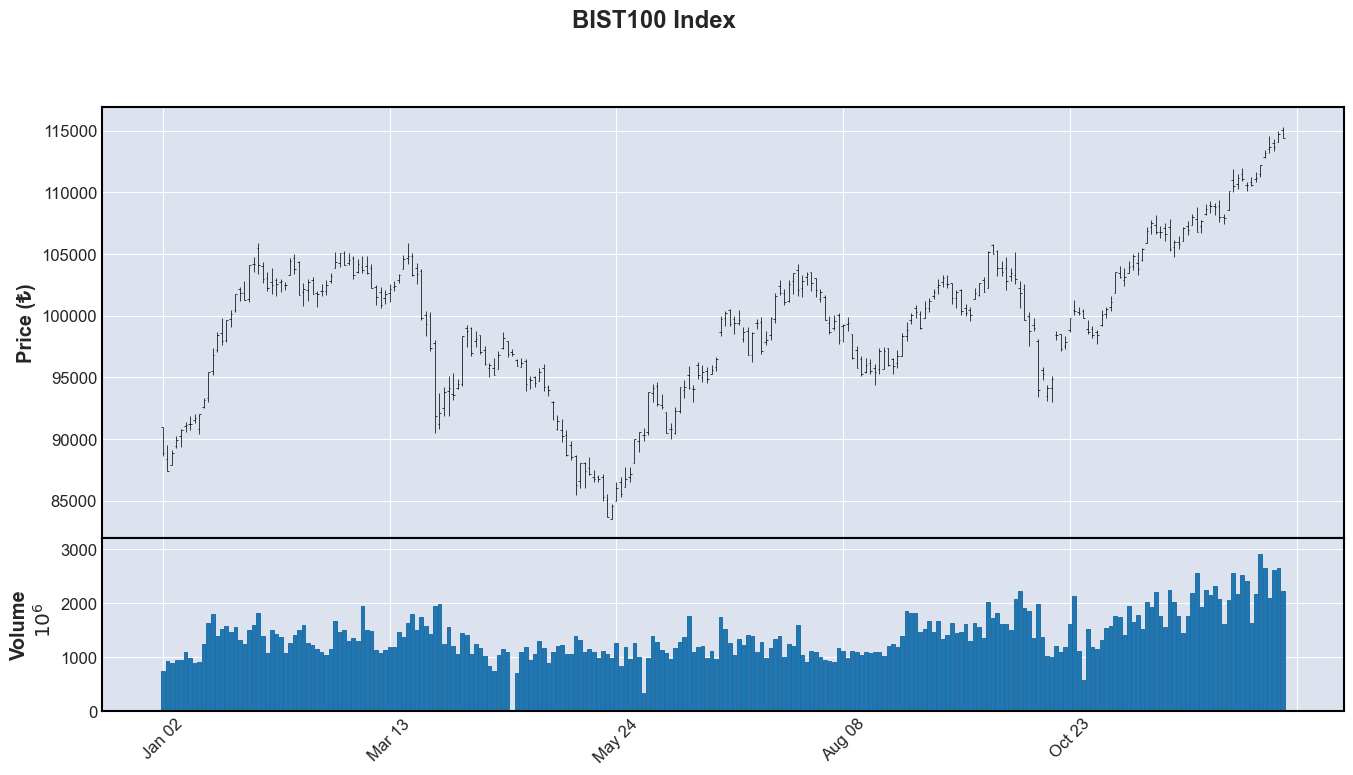

Total days: 248


In [2]:
# imports
import numpy as np
import pandas_datareader.data as web
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime

# fetch data
begin_date = datetime(2019,1, 1)
end_date = datetime(2019, 12, 31)
data = web.DataReader('XU100.IS', 'yahoo', begin_date, end_date)

# plot data
mpf.plot(data, volume=True,
         figscale=1.5, figratio=(2,1), 
         title='BIST100 Index',
         ylabel='Price (₺)',
         ylabel_lower='Volume')
mpf.show()

print('Total days:', len(data.index))

## Algorithm (Position Class)

In [3]:
class Position():

    def __init__(self, data, entry_day_index):
        self.data = data
        self.entry_day_index = entry_day_index
        self.current_day_index = entry_day_index
        self.entry_price = data['Open'][entry_day_index]
        self.stop_price = self.entry_price * (1 + STOP_PRICE_PERC)
        self.take_profit_price = self.entry_price * (1 + TAKE_PROFIT_PERC)
        self.rebuy_price = self.entry_price * (1 + REBUY_PERC)
        self.profit = 0.0
        self.status = 'open'
    
    def update(self):
        if (self.status == 'closed') or (self.current_day_index + 1 >= len(self.data.index)):
            return
        self.current_day_index += 1
        current_price_high = self.data["High"][self.current_day_index]
        current_price_low = self.data["Low"][self.current_day_index]
        if self.status == 'triggered':
            if self.status == 'rebuyed':
                if (self.take_profit_price >= current_price_low) and (self.take_profit_price <= current_price_high):
                    self.status = 'closed'
                    self.profit += self.take_profit_price - self.rebuy_price
                if (self.stop_price >= current_price_low) and (self.stop_price <= current_price_high):
                    self.status = 'closed'
                    self.profit += self.stop_price - self.rebuy_price
            else:
                if (self.rebuy_price >= current_price_low) and (self.rebuy_price <= current_price_high):
                    self.status = 'rebuyed'
                    self.stop_price = self.rebuy_price * (1 + STOP_PRICE_PERC)
                    self.take_profit_price = self.rebuy_price * (1 + TAKE_PROFIT_PERC)
        else:
            if (self.take_profit_price >= current_price_low) and (self.take_profit_price <= current_price_high):
                self.status = 'closed'
                self.profit += self.take_profit_price - self.entry_price
            if (self.stop_price >= current_price_low) and (self.stop_price <= current_price_high):
                self.status = 'triggered'
                self.profit += self.stop_price - self.entry_price

    def get_lifetime(self):
        return int(self.current_day_index - self.entry_day_index + 1)

## Simulation

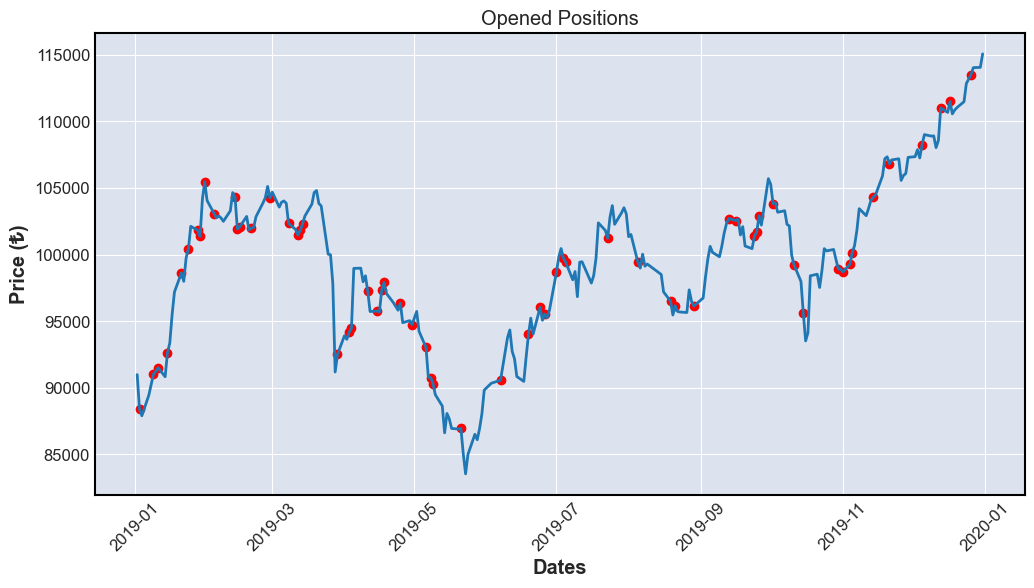

Randomly selected 62 days.


In [4]:
# select random days
day_indexes = np.random.default_rng().choice(len(data.index), size=len(data.index) // 4, replace=False)
day_indexes.sort()


# open positions
positions = [Position(data, day_index) for day_index in day_indexes]

# simulate
for day_index in range(len(data.index)):
    for position in positions:
        position.update()

plt.figure(figsize=(12,6))
plt.title('Opened Positions')
plt.ylabel('Price (₺)')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.plot(data['Open'][day_indexes].index, data['Open'][day_indexes], 'ro')
plt.plot(data.index, data['Open'])
plt.show()

print('Randomly selected', len(day_indexes), 'days.')

## Analize Results

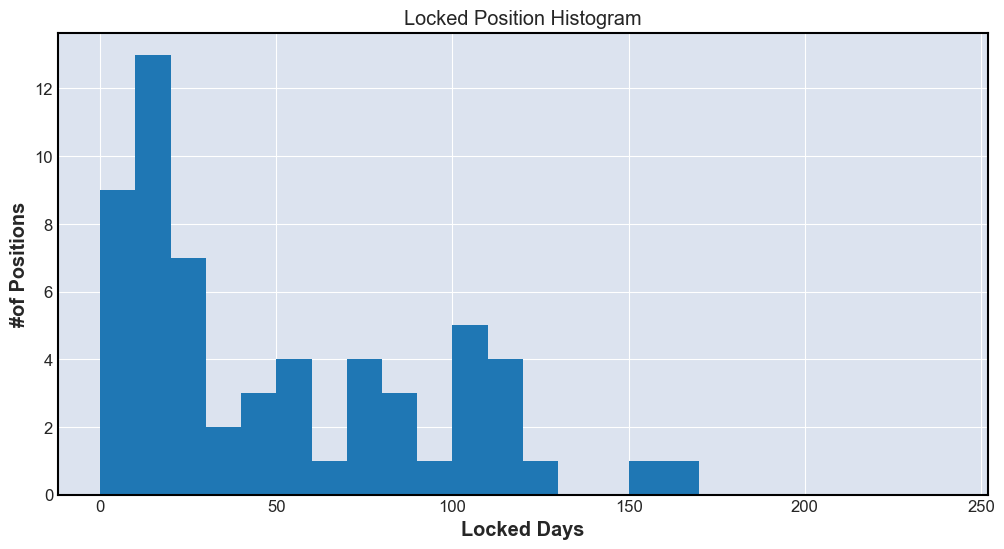

Total closed positions:      59
Unfinished position count:   3
Total profit percentage:     -7.12704515214428%


In [5]:
total_wasted_money = 0.0
total_profit = 0.0
discarded_count = 0
locked_days = []


for position in positions:
    if position.status == 'triggered' or position.status == 'closed':
        total_wasted_money += position.entry_price
        if position.status == 'rebuyed':
            total_wasted_money += position.rebuy_price
            
        total_profit += position.profit
        locked_days.append(position.get_lifetime())
    else:
        discarded_count += 1

plt.figure(figsize=(12,6))
plt.xlabel('Locked Days')
plt.ylabel('#of Positions')
plt.title('Locked Position Histogram')
plt.hist(locked_days, bins=range(0,len(data.index),10))
plt.show()
    
print("Total closed positions:     ", len(positions) - discarded_count)
print("Unfinished position count:  ", discarded_count)
print("Total profit percentage:    ", f"{(total_profit / total_wasted_money) * 100}%")

# Conclusion

TODO

Written by ***Berktuğ Kaan Özkan***.